In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import plotly.express as px
import geopandas as gpd
import datetime as dt
import numpy as np
from sklearn import preprocessing

engine = create_engine('sqlite:///mta.db').connect()

In [116]:
#import data from SQL files
all_data = pd.read_sql_query('''SELECT * FROM turnstiles_df_clean''', con = engine)
station_total_monthly_year = pd.read_sql_query('''SELECT STATION, YEAR, SUM(ENTRIES) AS 'MONTHLY_ENTRIES' FROM turnstiles_df_clean GROUP BY STATION, YEAR''', con = engine)
total_weekday_year = pd.read_sql_query('''SELECT STATION, YEAR, SUM(BUSYNESS) AS 'MONTHLY_BUSYNESS' FROM turnstiles_df_clean WHERE day_of_week_num BETWEEN 0 AND 5 GROUP BY STATION, YEAR''', con = engine)

In [122]:
station_total_monthly_year['STATION'].unique().shape

(473,)

Text(0.5, 1.0, 'NYC Subway Foot Traffic')

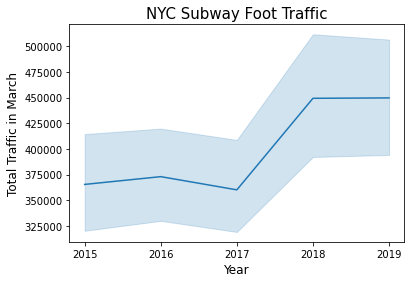

In [118]:
#Growth of turnstile traffic over year
sns.lineplot(data = station_total_monthly_year, x = 'YEAR', y = 'MONTHLY_ENTRIES')
plt.ylabel('Total Traffic in March', size = 12)
plt.locator_params(axis = 'x', nbins = 5)
plt.xlabel('Year', size = 12)
plt.title('NYC Subway Foot Traffic', size = 15)

In [3]:
#First I'm going to examine the average growth for each station between 2015-2019
def find_growth (dataframe, metric):
    dataframe['PCT_CHANGE'] = dataframe.groupby(['STATION'])[metric].pct_change()
    mean_df= dataframe.groupby('STATION')[['PCT_CHANGE']].mean().reset_index()
    return dataframe, mean_df

all_week, all_week_mean = find_growth(station_total_monthly_year, 'MONTHLY_BUSYNESS')
weekdays, weekdays_mean = find_growth(total_weekday_year, 'MONTHLY_BUSYNESS')

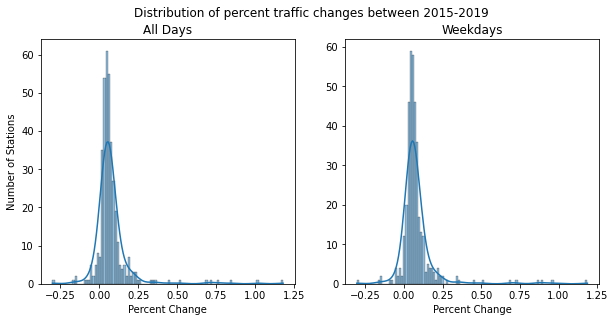

In [4]:
#Examine histogram to determine if there might be outliers
plt.figure(figsize= [10,4.5])
plt.suptitle('Distribution of percent traffic changes between 2015-2019')
plt.subplot(1,2,1)
sns.histplot(all_week_mean['PCT_CHANGE'], kde = 'True')
plt.title('All Days')
plt.xlabel('Percent Change')
plt.ylabel('Number of Stations')
plt.subplot(1,2,2)
sns.histplot(weekdays_mean['PCT_CHANGE'], kde = 'True')
plt.title('Weekdays')
plt.xlabel('Percent Change')
plt.ylabel(' ')
plt.savefig('Overall_Change_Hist.svg')
#Good enough for a government job

<ipython-input-5-7dbeea5cc51d>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Overall_Change.svg', bbox = 'Tight');


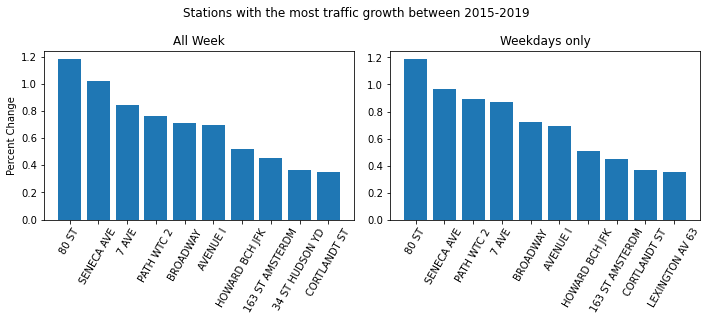

In [5]:
#Plot the top ten stations for all days and weekdays. 
# Hypothesis: growing residential areas will show up in top ten for weekdays only. 
plt.figure(figsize = [10,4.5])
plt.suptitle('Stations with the most traffic growth between 2015-2019')
plt.subplot(1,2,1)
all_week_mean.sort_values('PCT_CHANGE', ascending = False, inplace = True)
plt.bar(all_week_mean['STATION'][:10], height = all_week_mean['PCT_CHANGE'][:10])
plt.xticks(rotation = 60)
plt.xlabel('')
plt.ylabel('Percent Change')
plt.title('All Week')
plt.subplot(1,2,2)
weekdays_mean.sort_values('PCT_CHANGE', ascending = False, inplace = True)
plt.bar(weekdays_mean['STATION'][:10], height = weekdays_mean['PCT_CHANGE'][:10])
plt.xticks(rotation = 60)
plt.title('Weekdays only')
plt.xlabel('')
plt.tight_layout()
plt.savefig('Overall_Change.svg', bbox = 'Tight');
#Only difference is Lexington Ave, my old station. Welcome to the least lively part of Manhattan! 

In [6]:
all_data

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,YEAR,ENTRIES,EXITS,BUSYNESS,DAY_OF_WEEK_NUM
0,3330796,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,07:00:00,2016-02-27 07:00:00.000000,2016,12.0,12.0,24.0,5
1,3330797,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,11:00:00,2016-02-27 11:00:00.000000,2016,83.0,105.0,188.0,5
2,3330798,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,15:00:00,2016-02-27 15:00:00.000000,2016,249.0,54.0,303.0,5
3,3330799,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,19:00:00,2016-02-27 19:00:00.000000,2016,404.0,76.0,480.0,5
4,3330800,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,23:00:00,2016-02-27 23:00:00.000000,2016,255.0,41.0,296.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4255835,3139203,TRAM2,R469,00-05-01,RIT ROOSEVELT,R,RIT,03/29/2019,05:00:00,2019-03-29 05:00:00.000000,2019,0.0,0.0,0.0,4
4255836,3139204,TRAM2,R469,00-05-01,RIT ROOSEVELT,R,RIT,03/29/2019,09:00:00,2019-03-29 09:00:00.000000,2019,0.0,4.0,4.0,4
4255837,3139205,TRAM2,R469,00-05-01,RIT ROOSEVELT,R,RIT,03/29/2019,13:00:00,2019-03-29 13:00:00.000000,2019,0.0,0.0,0.0,4
4255838,3139206,TRAM2,R469,00-05-01,RIT ROOSEVELT,R,RIT,03/29/2019,17:00:00,2019-03-29 17:00:00.000000,2019,0.0,0.0,0.0,4


In [213]:
#Okay, I'm going to need to get more granular with this analysis. 
def find_time_interval(dataframe):
    dataframe['DATE_TIME'] = pd.to_datetime(dataframe['DATE_TIME'])
    dataframe = dataframe.groupby(['STATION', 'DATE_TIME', 'YEAR'], as_index = False)[['ENTRIES', 'EXITS', 'BUSYNESS']].sum()
    dataframe['INTERVAL'] = dataframe.groupby(['STATION', 'YEAR'])[['DATE_TIME']].diff(1).interpolate(method = 'bfill')
    return dataframe
all_data_interval = find_time_interval(all_data)
all_data_interval.head(20)

,STATION,DATE_TIME,YEAR,ENTRIES,EXITS,BUSYNESS,INTERVAL
0,1 AVE,2015-02-28 07:00:00,2015,408.0,600.0,1008.0,0 days 04:00:00
1,1 AVE,2015-02-28 11:00:00,2015,1951.0,2613.0,4564.0,0 days 04:00:00
2,1 AVE,2015-02-28 15:00:00,2015,4119.0,4170.0,8289.0,0 days 04:00:00
3,1 AVE,2015-02-28 19:00:00,2015,4876.0,5857.0,10733.0,0 days 04:00:00
4,1 AVE,2015-02-28 23:00:00,2015,4739.0,5613.0,10352.0,0 days 04:00:00
5,1 AVE,2015-03-01 03:00:00,2015,2655.0,2313.0,4968.0,0 days 04:00:00
6,1 AVE,2015-03-01 07:00:00,2015,449.0,561.0,1010.0,0 days 04:00:00
7,1 AVE,2015-03-01 11:00:00,2015,1457.0,1840.0,3297.0,0 days 04:00:00
8,1 AVE,2015-03-01 15:00:00,2015,3747.0,4137.0,7884.0,0 days 04:00:00
9,1 AVE,2015-03-01 19:00:00,2015,3834.0,4861.0,8695.0,0 days 04:00:00


In [282]:
#Remove intervals that are greater than twelves hours and less than 5 min - indicates something went wrong
all_data_interval = all_data_interval[all_data_interval['INTERVAL'] <= pd.Timedelta(value = 12, unit = 'hour')]
all_data_interval = all_data_interval[all_data_interval['INTERVAL'] >= pd.Timedelta(value = 10, unit = 'minute')]
all_data_interval.describe()

,YEAR,ENTRIES,EXITS,BUSYNESS,INTERVAL,ENTRIES_HR,EXITS_HR,BUSYNESS_HR
count,370651.000000,370651.000000,370651.000000,370651.000000,370651,370651.000000,370651.000000,3.706510e+05
mean,2017.133349,1925.389275,1431.660654,3357.049928,0 days 03:33:17.590676944,699.007140,525.646064,7.347919e+04
std,1.426966,3251.278752,2614.133549,5514.049653,0 days 00:59:33.698894085,1600.644275,1267.439462,1.644413e+05
min,2015.000000,0.000000,0.000000,0.000000,0 days 01:00:00,0.000000,0.000000,0.000000e+00
25%,2016.000000,249.000000,190.000000,541.000000,0 days 04:00:00,71.333333,53.000000,9.290960e+03
50%,2017.000000,840.000000,554.000000,1528.000000,0 days 04:00:00,237.250000,157.500000,2.581500e+04
75%,2018.000000,2145.000000,1453.000000,3568.000000,0 days 04:00:00,644.750000,438.250000,6.601500e+04
max,2019.000000,42235.000000,32735.000000,69405.000000,0 days 12:00:00,34146.261801,22762.000000,3.286683e+06


In [286]:
#Add in a few features for easier analysis and propagation of information

all_data_interval['ENTRIES_HR'] = all_data_interval['ENTRIES']/(all_data_interval['INTERVAL']/dt.timedelta(hours = 1))
all_data_interval['EXITS_HR'] = all_data_interval['EXITS']/(all_data_interval['INTERVAL']/dt.timedelta(hours = 1))
all_data_interval['BUSYNESS_HR'] = all_data_interval['BUSYNESS']/(all_data_interval['INTERVAL']/dt.timedelta(hours = 1))
all_data_interval

,STATION,DATE_TIME,YEAR,ENTRIES,EXITS,BUSYNESS,INTERVAL,ENTRIES_HR,EXITS_HR,BUSYNESS_HR
0,1 AVE,2015-02-28 07:00:00,2015,408.0,600.0,1008.0,0 days 04:00:00,102.00,150.00,252.00
1,1 AVE,2015-02-28 11:00:00,2015,1951.0,2613.0,4564.0,0 days 04:00:00,487.75,653.25,1141.00
2,1 AVE,2015-02-28 15:00:00,2015,4119.0,4170.0,8289.0,0 days 04:00:00,1029.75,1042.50,2072.25
3,1 AVE,2015-02-28 19:00:00,2015,4876.0,5857.0,10733.0,0 days 04:00:00,1219.00,1464.25,2683.25
4,1 AVE,2015-02-28 23:00:00,2015,4739.0,5613.0,10352.0,0 days 04:00:00,1184.75,1403.25,2588.00
...,...,...,...,...,...,...,...,...,...,...
629797,ZEREGA AVE,2019-03-29 05:00:00,2019,68.0,68.0,136.0,0 days 04:00:00,17.00,17.00,34.00
629798,ZEREGA AVE,2019-03-29 09:00:00,2019,1149.0,498.0,1647.0,0 days 04:00:00,287.25,124.50,411.75
629799,ZEREGA AVE,2019-03-29 13:00:00,2019,509.0,348.0,857.0,0 days 04:00:00,127.25,87.00,214.25
629800,ZEREGA AVE,2019-03-29 17:00:00,2019,608.0,606.0,1214.0,0 days 04:00:00,152.00,151.50,303.50


In [287]:
test_df = all_data_interval.copy()
test_df.set_index(['STATION', 'DATE_TIME'], inplace = True)
test_df

YEAR  ENTRIES   EXITS  BUSYNESS  \
STATION    DATE_TIME                                              
1 AVE      2015-02-28 07:00:00  2015    408.0   600.0    1008.0   
           2015-02-28 11:00:00  2015   1951.0  2613.0    4564.0   
           2015-02-28 15:00:00  2015   4119.0  4170.0    8289.0   
           2015-02-28 19:00:00  2015   4876.0  5857.0   10733.0   
           2015-02-28 23:00:00  2015   4739.0  5613.0   10352.0   
...                              ...      ...     ...       ...   
ZEREGA AVE 2019-03-29 05:00:00  2019     68.0    68.0     136.0   
           2019-03-29 09:00:00  2019   1149.0   498.0    1647.0   
           2019-03-29 13:00:00  2019    509.0   348.0     857.0   
           2019-03-29 17:00:00  2019    608.0   606.0    1214.0   
           2019-03-29 21:00:00  2019    364.0   720.0    1084.0   

                                      INTERVAL  ENTRIES_HR  EXITS_HR  \
STATION    DATE_TIME                                                   
1 AVE      2015-02-28 07:00:00 0 days 04:00:00      102.00    150.00   
           2015-02-28 11:00:00 0 days 04:00:00      487.75    653.25   
           2015-02-28 15:00:00 0 days 04:00:00     1029.75   1042.50   
           2015-02-28 19:00:00 0 days 04:00:00     1219.00   1464.25   
           2015-02-28 23:00:00 0 days 04:00:00     1184.75   1403.25   
...                                        ...         ...       ...   
ZEREGA AVE 2019-03-29 05:00:00 0 days 04:00:00       17.00     17.00   
           2019-03-29 09:00:00 0 days 04:00:00      287.25    124.50   
           2019-03-29 13:00:00 0 days 04:00:00      127.25     87.00   
           2019-03-29 17:00:00 0 days 04:00:00      152.00    151.50   
           2019-03-29 21:00:00 0 days 04:00:00       91.00    180.00   

                                BUSYNESS_HR  
STATION    DATE_TIME                         
1 AVE      2015-02-28 07:00:00       252.00  
           2015-02-28 11:00:00      1141.00  
           2015-02-28 15:00:00      2072.25  
           2015-02-28 19:00:00      2683.25  
           2015-02-28 23:00:00      2588.00  
...                                     ...  
ZEREGA AVE 2019-03-29 05:00:00        34.00  
           2019-03-29 09:00:00       411.75  
           2019-03-29 13:00:00       214.25  
           2019-03-29 17:00:00       303.50  
           2019-03-29 21:00:00       271.00  

[370651 rows x 8 columns]

In [288]:
data_hourly = test_df.groupby(level=0).apply(lambda x: x.reset_index(level=0, drop=True).resample("1H").interpolate(method = 'ffill'))
data_hourly.reset_index(inplace = True)
data_hourly
data_hourly['YEAR'] = data_hourly['DATE_TIME'].dt.year
data_hourly['DAY_OF_WEEK'] = data_hourly['DATE_TIME'].dt.dayofweek
data_hourly['HOUR'] = data_hourly['DATE_TIME'].dt.hour
data_hourly.drop(['ENTRIES', 'EXITS', 'BUSYNESS'], axis = 1, inplace = True)
data_hourly

,STATION,DATE_TIME,YEAR,INTERVAL,ENTRIES_HR,EXITS_HR,BUSYNESS_HR,DAY_OF_WEEK,HOUR
0,1 AVE,2015-02-28 07:00:00,2015,0 days 04:00:00,102.00,150.00,252.0,5,7
1,1 AVE,2015-02-28 08:00:00,2015,0 days 04:00:00,102.00,150.00,252.0,5,8
2,1 AVE,2015-02-28 09:00:00,2015,0 days 04:00:00,102.00,150.00,252.0,5,9
3,1 AVE,2015-02-28 10:00:00,2015,0 days 04:00:00,102.00,150.00,252.0,5,10
4,1 AVE,2015-02-28 11:00:00,2015,0 days 04:00:00,487.75,653.25,1141.0,5,11
...,...,...,...,...,...,...,...,...,...
12697794,ZEREGA AVE,2019-03-29 17:00:00,2019,0 days 04:00:00,152.00,151.50,303.5,4,17
12697795,ZEREGA AVE,2019-03-29 18:00:00,2019,0 days 04:00:00,152.00,151.50,303.5,4,18
12697796,ZEREGA AVE,2019-03-29 19:00:00,2019,0 days 04:00:00,152.00,151.50,303.5,4,19
12697797,ZEREGA AVE,2019-03-29 20:00:00,2019,0 days 04:00:00,152.00,151.50,303.5,4,20


In [331]:
station_hourly = data_hourly.groupby(['STATION', 'HOUR', 'DAY_OF_WEEK', 'YEAR'], as_index = False)[['ENTRIES_HR', 'EXITS_HR', 'BUSYNESS_HR']].mean()
station_hourly.head(50)

,STATION,HOUR,DAY_OF_WEEK,YEAR,ENTRIES_HR,EXITS_HR,BUSYNESS_HR
0,1 AVE,0,0,2015,1601.153409,1065.943182,2667.096591
1,1 AVE,0,0,2016,1554.629808,1509.245192,3063.875000
2,1 AVE,0,0,2017,1589.336538,1658.509615,3247.846154
3,1 AVE,0,0,2018,1476.933962,1336.688679,2813.622642
4,1 AVE,0,0,2019,922.833333,805.812500,1728.645833
5,1 AVE,0,1,2015,1618.380682,1093.636364,2712.017045
6,1 AVE,0,1,2016,1573.975962,1537.668269,3111.644231
7,1 AVE,0,1,2017,1604.879808,1681.543269,3286.423077
8,1 AVE,0,1,2018,1492.384615,1357.788462,2850.173077
9,1 AVE,0,1,2019,1200.115385,1116.346154,2316.461538


<AxesSubplot:xlabel='HOUR', ylabel='BUSYNESS_HR'>

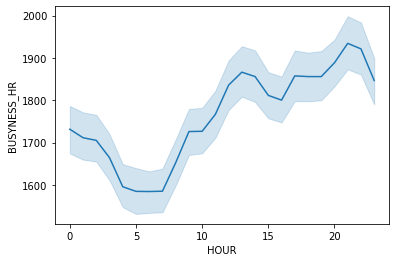

In [332]:
#Figure out if both morning and evening show surges in traffic
sns.lineplot(data=station_hourly, x = 'HOUR', y = 'BUSYNESS_HR')

#Only the morning shows a surge, use this for commuter data

In [307]:
#Remove outliers, not the correct method since this is a Poisson distribution.
# station_hourly = station_hourly[station_hourly['BUSYNESS_HR'] <= station_hourly['BUSYNESS_HR'].quantile(.997)]
# station_hourly

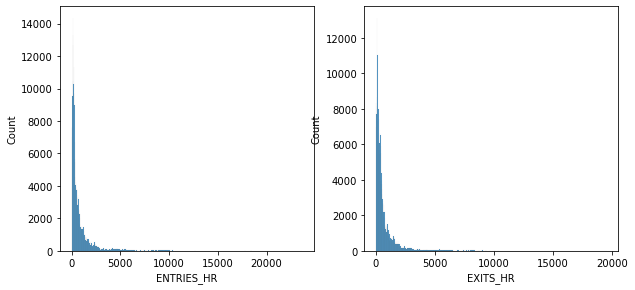

In [322]:
#Check histogram and stats on new station_hourly
plt.figure(figsize = [10, 4.5])
plt.subplot(1,2,1)
sns.histplot(station_hourly['ENTRIES_HR'])
plt.subplot(1,2,2)
sns.histplot(station_hourly['EXITS_HR']);
#I guess it makes sense since some stations will see a lot of traffic

In [344]:
#Check to make sure the busy stations are in the top
station_hourly.sort_values(['BUSYNESS_HR'], ascending = False).head(50)
station_hourly['YEAR']
station_hourly.head(5)
#This makes sense

,STATION,HOUR,DAY_OF_WEEK,YEAR,ENTRIES_HR,EXITS_HR,BUSYNESS_HR
0,1 AVE,0,0,2015,1601.153409,1065.943182,2667.096591
1,1 AVE,0,0,2016,1554.629808,1509.245192,3063.875000
2,1 AVE,0,0,2017,1589.336538,1658.509615,3247.846154
3,1 AVE,0,0,2018,1476.933962,1336.688679,2813.622642
4,1 AVE,0,0,2019,922.833333,805.812500,1728.645833


In [434]:
#Okay, I'm happy enough with the data - I'm going to put it into a SQL db to query
# station_hourly.rename(columns = {'ENTRIES/HR':'ENTRIES_HR', 'EXITS/HR':'EXITS_HR', 'BUSYNESS/HR':'BUSYNESS_HR'}, inplace = True)
# station_hourly.columns
print(station_hourly['YEAR'])
station_hourly.to_sql('station_hourly_new', if_exists = 'replace', con = engine)
#Now lets query! 
all_changes = pd.read_sql('''SELECT STATION, YEAR, AVG(BUSYNESS_HR) as 'AVG_BUSYNESS', AVG(EXITS_HR) as 'AVG_EXITS', AVG(ENTRIES_HR) as 'AVG_ENTRIES' FROM station_hourly_new GROUP BY STATION, YEAR''', con = engine)
commuters = pd.read_sql('''SELECT STATION, YEAR, AVG(ENTRIES_HR) as 'AVG_ENTRIES' FROM Station_Hourly WHERE hour BETWEEN 6 and 10 AND day_of_week BETWEEN 0 and 4 GROUP BY STATION, YEAR''', con = engine)
commuters

0         2015
1         2016
2         2017
3         2018
4         2019
          ... 
316507    2019
316508    2016
316509    2017
316510    2018
316511    2019
Name: YEAR, Length: 316512, dtype: int64


,STATION,YEAR,AVG_ENTRIES
0,1 AVE,2015,1569.737099
1,1 AVE,2016,1522.413632
2,1 AVE,2017,1557.664038
3,1 AVE,2018,1433.447736
4,1 AVE,2019,1005.988974
...,...,...,...
1879,YORK ST,2019,574.759615
1880,ZEREGA AVE,2016,76.259773
1881,ZEREGA AVE,2017,89.402308
1882,ZEREGA AVE,2018,77.197467


In [689]:
#Calculate percent change for commuter traffic
commuter, commuter_mean = find_growth(commuters, 'AVG_ENTRIES')
commuter_mean.rename(columns = {'PCT_CHANGE':'PCT_CHANGE_COMM'}, inplace = True)
commuter_mean.shape
commuter_order = commuter_mean.sort_values('PCT_CHANGE_COMM', ascending = False).head(10)
commuter_order
# commuter.groupby(['STATION'], as_index = False)[['PCT_CHANGE']].mean().sort_values('PCT_CHANGE', ascending = False).head(20)

(473, 2)

In [690]:
all_change, all_change_mean = find_growth(all_changes, 'AVG_ENTRIES')
all_change_mean.rename(columns = {'PCT_CHANGE':'PCT_CHANGE_ALL'}, inplace = True)
all_change_mean.shape
# all_change_order = all_change_mean.sort_values('PCT_CHANGE_ALL', ascending = False).head(10)
# all_change = all_change.sort_values('PCT_CHANGE_ALL', ascending = False).head(20)
# all_change_order

(473, 2)

In [691]:
norm_change = pd.merge(all_change_mean, commuter_mean, on = 'STATION')
norm_change['N_CHANGE'] = norm_change['PCT_CHANGE_COMM']/norm_change['PCT_CHANGE_ALL']
norm_change_pos = norm_change[norm_change['PCT_CHANGE_COMM'] > 0]
norm_change_order = norm_change_pos.sort_values('N_CHANGE', ascending = False).head(10)
norm_change.to_sql('norm_change', if_exists = 'replace', con = engine)
norm_change['STATION'].shape

(473,)

<ipython-input-700-401ff905dcee>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Overall_Change.svg', bbox = 'Tight');


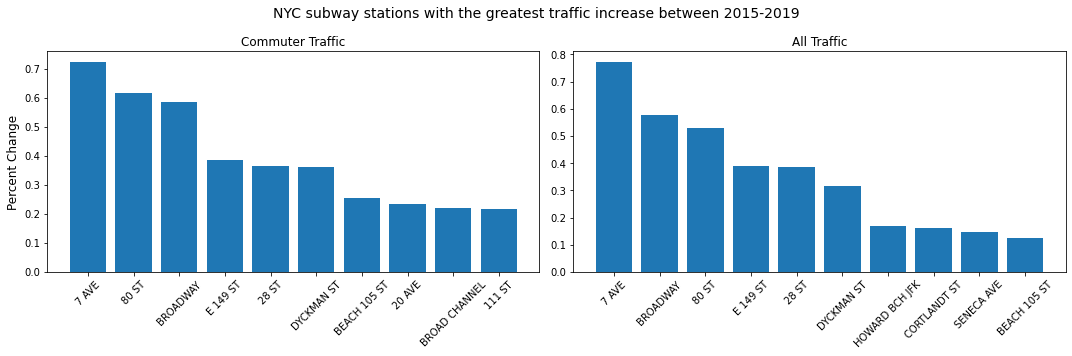

In [700]:
plt.figure(figsize = [15, 5])
plt.suptitle('NYC subway stations with the greatest traffic increase between 2015-2019', size = 14)
plt.subplot(1,2,1)
plt.bar(commuter_order['STATION'], commuter_order['PCT_CHANGE_COMM'])
plt.xlabel('')
plt.title('Commuter Traffic')
plt.xticks(rotation = 45)
plt.ylabel('Percent Change', size = 12)
plt.subplot(1,2,2)
plt.xticks(rotation = 45)
plt.bar(all_change_order['STATION'], all_change_order['PCT_CHANGE_ALL'])
plt.title('All Traffic')
plt.tight_layout()
plt.savefig('Overall_Change.svg', bbox = 'Tight');

<ipython-input-701-a2c30d5c63d1>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Commuter_Change.svg', bbox = 'Tight');


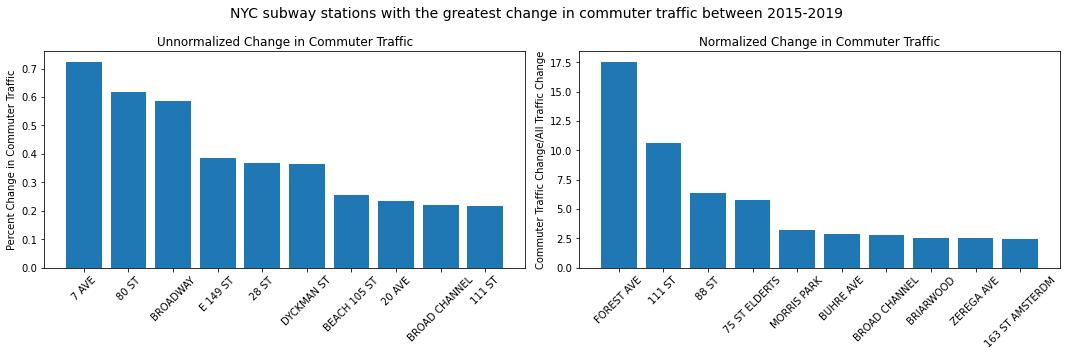

In [701]:
plt.figure(figsize = [15, 5])
plt.suptitle('NYC subway stations with the greatest change in commuter traffic between 2015-2019', size = 14)
plt.subplot(1,2,1)
plt.bar(commuter_order['STATION'], commuter_order['PCT_CHANGE_COMM'])
plt.xticks(rotation = 45)
plt.ylabel('Percent Change in Commuter Traffic')
plt.title('Unnormalized Change in Commuter Traffic')
plt.subplot(1,2,2)
plt.title('Normalized Change in Commuter Traffic')
plt.bar(norm_change_order['STATION'], norm_change_order['N_CHANGE'])
plt.xticks(rotation = 45)
plt.ylabel('Commuter Traffic Change/All Traffic Change', size = 10)
plt.tight_layout()
plt.savefig('Commuter_Change.svg', bbox = 'Tight');

In [669]:
# Load data into SQL that includes geographical information
geo_data = pd.read_csv('DOITT_SUBWAY_STATION_01_13SEPT2010.csv')
geo_data['NAME'].head(40)
geo_data.rename(columns = {'NAME': 'STATION'}, inplace = True)
geo_data['STATION'] = geo_data['STATION'].str.upper()
geo_data['STATION'].head(40)
mymap = {'AV$':'AVE', 'STS$':'ST', '/':'', '-':'', 'CO$': 'COL', 'PLACE$':'PL', 'AVENUE$':'AVE', 'PARKWAY$': 'PWY', 'PK$':'PARK', 'BL$':'BLVD', 'ROAD$':'RD'}
for abbr1, abbr2 in mymap.items():
      geo_data['STATION'] = geo_data['STATION'].str.replace(abbr1, abbr2, regex=True)
geo_data['STATION'] = geo_data['STATION'].str.replace('  ', ' ')
geo_data['STATION'].head(40)
geo_data.drop(['URL', 'OBJECTID', 'LINE', 'NOTES'], axis = 1, inplace = True)
geo_data.to_sql('geo_data', if_exists = 'replace', con = engine)
geo_data

,STATION,the_geom
0,ASTOR PL,POINT (-73.99106999861966 40.73005400028978)
1,CANAL ST,POINT (-74.00019299927328 40.71880300107709)
2,50TH ST,POINT (-73.98384899986625 40.76172799961419)
3,BERGEN ST,POINT (-73.97499915116808 40.68086213682956)
4,PENNSYLVANIA AVE,POINT (-73.89488591154061 40.66471445143568)
...,...,...
468,CONEY ISLAND STILLWELL AVE,POINT (-73.9812359981396 40.57728100006751)
469,34TH ST HUDSON YARDS,POINT (-74.00219709442206 40.75544635961596)
470,72ND ST,POINT (-73.95836178682246 40.76880251014895)
471,86TH ST,POINT (-73.95177090964917 40.77786104333163)


In [670]:
geo_data.to_csv('geo_data.csv')
geo_data

,STATION,the_geom
0,ASTOR PL,POINT (-73.99106999861966 40.73005400028978)
1,CANAL ST,POINT (-74.00019299927328 40.71880300107709)
2,50TH ST,POINT (-73.98384899986625 40.76172799961419)
3,BERGEN ST,POINT (-73.97499915116808 40.68086213682956)
4,PENNSYLVANIA AVE,POINT (-73.89488591154061 40.66471445143568)
...,...,...
468,CONEY ISLAND STILLWELL AVE,POINT (-73.9812359981396 40.57728100006751)
469,34TH ST HUDSON YARDS,POINT (-74.00219709442206 40.75544635961596)
470,72ND ST,POINT (-73.95836178682246 40.76880251014895)
471,86TH ST,POINT (-73.95177090964917 40.77786104333163)


In [699]:
# geo = pd.read_sql('''SELECT norm_change.STATION, geo_data.STATION, geo_data.the_geom from geo_data''', con = engine)
# geo
norm_geo_merge = pd.read_sql('''SELECT geo_data.station, geo_data.the_geom, norm_change.n_change FROM geo_data INNER JOIN norm_change ON geo_data.STATION = norm_change.STATION''', con = engine)
norm_geo_merge.to_csv('norm_geo_merge.csv')
